<a href="https://colab.research.google.com/github/Ramkanc/Capstone_IIITH/blob/Capstone1_RamK_Multi_torch/Capstone1_RamK_Multi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python==4.8.0.76

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 10.5 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.10.0.84
    Uninstalling opencv-python-4.10.0.84:
      Successfully uninstalled opencv-python-4.10.0.84


In [2]:
# Import Libraries
import torch
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F

from torchsummary import summary
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir
import pandas as pd

In [3]:
import PIL
from PIL import Image

In [4]:
import cv2

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)

100%|██████████| 1.04G/1.04G [00:10<00:00, 102MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1


In [7]:
found_directories = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
found_files =[f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
print (found_directories)
print (found_files)

['Images']
['captions.txt']


In [18]:
image_dir= os.path.join(path, found_directories[0])
print(image_dir)

/root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1/Images


In [19]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader

# Define a custom dataset class
class CustomImageDataset(Dataset):
    def __init__(self, image_dir):
        """
        Args:
            image_dir (str): Path to the directory with images.
        """
        self.image_dir = image_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('jpg', 'png', 'jpeg'))]

    def preprocess_image_opencv(self, image_path):
        # Read the image using OpenCV
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Image not found at {image_path}")

        # Resize to 224x224
        image_resized = cv2.resize(image, (224, 224))

        # Convert from BGR to RGB
        image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)

        # Normalize pixel values to [0, 1]
        image_normalized = image_rgb / 255.0

        # Reshape to CxHxW
        image_reshaped = np.transpose(image_normalized, (2, 0, 1))

        # Convert to PyTorch tensor
        image_tensor = torch.tensor(image_reshaped, dtype=torch.float32)

        # Normalize using ImageNet mean and std
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        image_tensor = (image_tensor - mean) / std

        return image_tensor

    def __len__(self):
        # Return the number of images
        return len(self.image_files)

    def __getitem__(self, idx):
        # Get the image path
        image_path = os.path.join(self.image_dir, self.image_files[idx])

        # Preprocess the image
        image_tensor = self.preprocess_image_opencv(image_path)

        # Return the processed tensor
        return image_tensor

# Define the directory containing images
#image_dir = "path_to_image_directory"  # Replace with your directory




Batch 1:
Shape: torch.Size([16, 3, 224, 224])
Type: torch.float32


In [ ]:
# Create an instance of the custom dataset
dataset = CustomImageDataset(image_dir)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [22]:
# Iterate over the DataLoader
for batch_idx, batch_images in enumerate(dataloader):
    print(f"Batch {batch_idx + 1}:")
    print(f"Shape: {batch_images.shape}")  # Expected: [batch_size, 3, 224, 224]
    print(f"Type: {batch_images.dtype}")  # Expected: torch.float32
    break

Batch 1:
Shape: torch.Size([32, 3, 224, 224])
Type: torch.float32


In [24]:
# Function to display a single image
def show_image(image_tensor):
    # Undo normalization for display (optional if you want raw pixel values)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    image_tensor = image_tensor * std + mean  # Denormalize

    # Convert from Tensor (CxHxW) to NumPy array (HxWxC)
    image_numpy = image_tensor.permute(1, 2, 0).numpy()
    image_numpy = np.clip(image_numpy, 0, 1)  # Clip values to [0, 1] for proper display

    # Display the image
    plt.imshow(image_numpy)
    plt.axis('off')

In [51]:
def display_images_from_dataloader(dataloader, dataset, num_images=10):
    images_shown = 0
    plt.figure(figsize=(15, 10))  # Adjust figure size for better visualization

    # Get the image file names from the dataset
    image_files = dataset.image_files

    for batch_idx, batch_images in enumerate(dataloader):
        for image_idx, image_tensor in enumerate(batch_images):
            if images_shown >= num_images:
                break

            # Get the corresponding image file name for the current image
            image_file_name = image_files[batch_idx * dataloader.batch_size + image_idx]

            plt.subplot(2, 5, images_shown + 1)  # Create a 2x5 grid for 10 images
            show_image(image_tensor)
            plt.title(image_file_name)  # Set the image file name as the title
            images_shown += 1

        if images_shown >= num_images:
            break

    plt.tight_layout()
    plt.show()

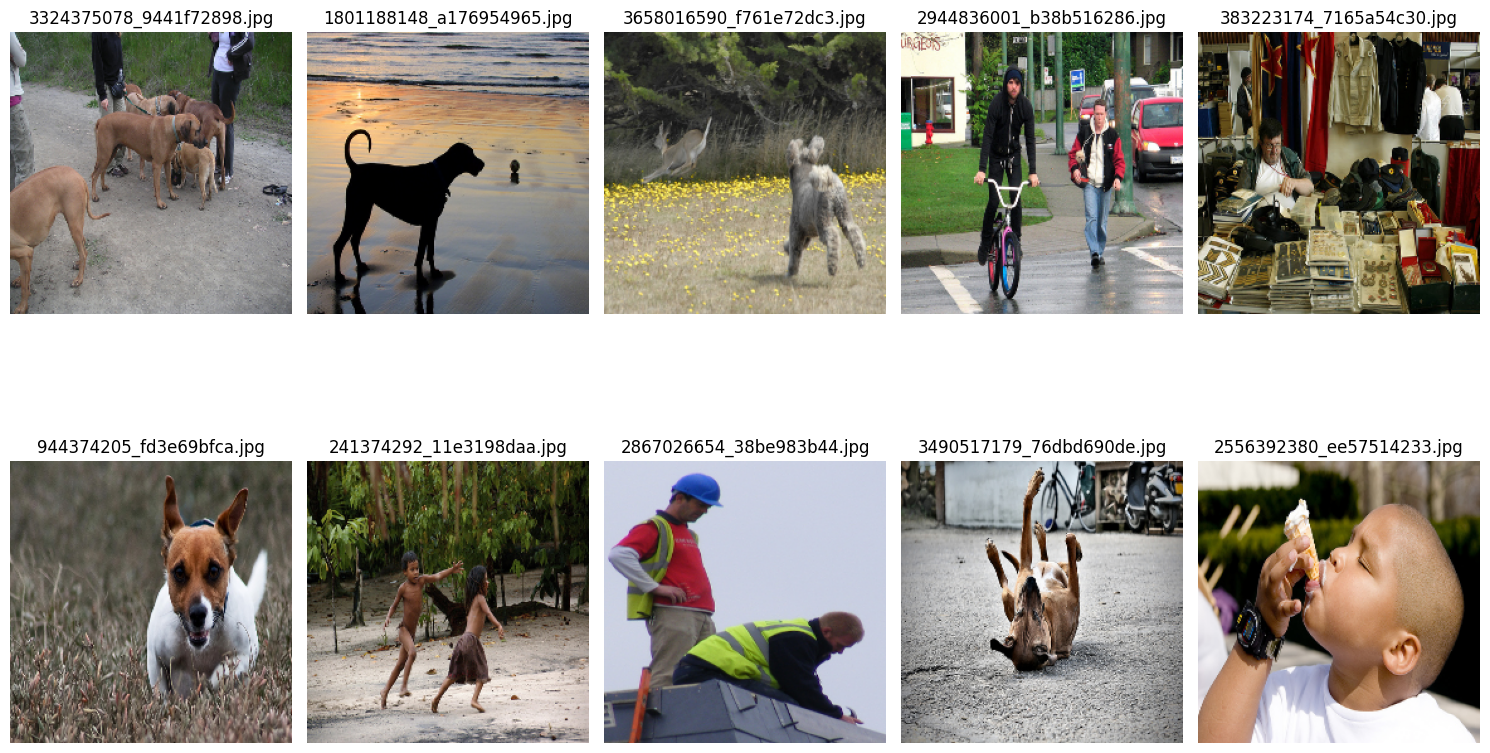

In [53]:
# Call the function to display images
display_images_from_dataloader(dataloader, dataset, num_images=10)

In [30]:
labels_file = os.path.join(path, found_files[0])

In [ ]:
# for line in open(labels_file, 'r'):
#     print(line)

In [35]:
raw_captions = pd.read_csv(labels_file, delimiter=',',header=0)

In [37]:
raw_captions.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [42]:
from transformers import BertTokenizer
import re

In [44]:
from transformers import BertTokenizer

def preprocess_text(text):
    """
    Preprocesses the caption text.

    Args:
        text (str): The caption text.

    Returns:
        str: The preprocessed caption text.
    """
    # Lowercase the text
    text = text.lower()

    # Remove punctuation (fixed regex for removing special characters)
    text = re.sub(r"[^a-zA-Z0-9 ]", "", text)

    # Add special tokens for start and end of sequence
    text = "[CLS] " + text + " [SEP]"

    return text

In [45]:
def tokenize_text(text, tokenizer, max_length=32):
    """
    Tokenizes the preprocessed caption text using BertTokenizer.

    Args:
        text (str): The preprocessed caption text.
        tokenizer (transformers.BertTokenizer): The tokenizer object.
        max_length (int): Maximum length for tokenized captions.

    Returns:
        list: A list of token IDs padded to max_length.
    """
    # Tokenize the text with padding and truncation
    tokenized_output = tokenizer(
        text,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    return tokenized_output["input_ids"].squeeze(0)  # Remove batch dimension

In [49]:
# Create a BertTokenizer instance
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Sample data
captions = raw_captions['caption'].tolist()

In [50]:
# Preprocess and tokenize each caption
for caption in captions:
    preprocessed_caption = preprocess_text(caption)
    token_ids = tokenize_text(preprocessed_caption, tokenizer)

    #print("Original Caption:", caption)
    #print("Preprocessed Caption:", preprocessed_caption)
    #print("Token IDs:", token_ids.tolist())  # Convert tensor to list for readability
    #print("-" * 20)

Streaming output truncated to the last 5000 lines.
Original Caption: A brown dog is running through a brown field .
Preprocessed Caption: [CLS] a brown dog is running through a brown field  [SEP]
Token IDs: [101, 101, 1037, 2829, 3899, 2003, 2770, 2083, 1037, 2829, 2492, 102, 102, 0, 0, 0, 0, 0, 0, 0]
--------------------
Original Caption: A brown dog is running through the field .
Preprocessed Caption: [CLS] a brown dog is running through the field  [SEP]
Token IDs: [101, 101, 1037, 2829, 3899, 2003, 2770, 2083, 1996, 2492, 102, 102, 0, 0, 0, 0, 0, 0, 0, 0]
--------------------
Original Caption: A brown dog with a collar runs in the dead grass with his tongue hanging out to the side .
Preprocessed Caption: [CLS] a brown dog with a collar runs in the dead grass with his tongue hanging out to the side  [SEP]
Token IDs: [101, 101, 1037, 2829, 3899, 2007, 1037, 9127, 3216, 1999, 1996, 2757, 5568, 2007, 2010, 4416, 5689, 2041, 2000, 102]
--------------------
Original Caption: a brown dog w